# Preprocessing

## Objetivos del Cuaderno

1. **Generación de Features Agregadas**: Crear nuevas características a partir de los datos originales para representar patrones de consumo de manera más significativa y reducir la dimensionalidad.

## Introducción

El dataset contiene información horaria del consumo energético de aproximadamente 130 viviendas durante un período de dos años. Cada registro incluye:
- **CUPS**: Identificador único de la vivienda.
- **Fecha**: Día específico del registro.
- **Hora**: Hora del día (1 a 24).
- **Consumo_kWh**: Consumo energético en kilovatios-hora.

Dado el volumen de datos, es necesario crear características agregadas que representen patrones de consumo a nivel diario, semanal, mensual, etc., para facilitar el análisis y el clustering.


## Preprocesamiento y Generación de Features

Antes de aplicar el clustering, comenzaremos con:
1. Preprocesamiento y Generación de Features
    - Justificación del Pipeline:
    El preprocesamiento sistemático es crítico porque:
        - **Consistencia**: Las estaciones tienen patrones de consumo fundamentalmente distintos.
        - **Robustez**: Las métricas propuestas (percentiles, FFT) capturan tanto comportamientos típicos como anomalías.
        - **Interpretabilidad**: La separación por contextos naturales (estaciones) facilita la acción sobre resultados.
2. **Creación de Features Agregadas**:
    **Subanálisis (por vivienda):**
    - Primavera
    - Verano
    - Otoño
    - Invierno
    - Análisis general

    **Métricas a calcular para cada parte:**
    | Variable                        | Descripción                                      |
    |---------------------------------|--------------------------------------------------|
    | Media y Desviación Estándar     | Tendencia central y dispersión                  |
    | Asimetría (Skewness)            | Simetría de la distribución                     |
    | Curtosis                        | Picudez/plenitud de la distribución             |
    | Energía (FFT)                   | Potencia acumulada de la señal                  |
    | Frecuencia dominante (FFT)      | Periodicidad más fuerte                         |
    | Mediana y percentiles (25, 75)  | Distribución robusta                            |

3. **Normalización de Datos**: Escalar las características para que todas tengan el mismo rango y no dominen el análisis.

Una vez que los datos estén preprocesados y las nuevas características estén listas, procederemos con la aplicación de K-Means y la evaluación de los resultados.

Imports

In [14]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("dataset/vertical_data", sep=";")

Funciones

In [16]:
def obtener_estacion(mes):
    if mes in [12, 1, 2]:
        return 'invierno'
    elif mes in [3, 4, 5]:
        return 'primavera'
    elif mes in [6, 7, 8]:
        return 'verano'
    else:
        return 'otoño'


def calcular_features(consumos):
    consumos = np.array(consumos)
    if len(consumos) < 2:
        return dict.fromkeys([
            'media', 'std', 'skewness', 'kurtosis',
            'energia_fft', 'frecuencia_dominante',
            'mediana', 'p25', 'p75'
        ], np.nan)

    media = np.mean(consumos)
    std = np.std(consumos)
    skewness = skew(consumos)
    kurt = kurtosis(consumos)

    fft_vals = fft(consumos)
    fft_powers = np.abs(fft_vals)**2
    energia = np.sum(fft_powers) / len(fft_powers)
    frec_dom = np.argmax(fft_powers[1:]) + 1 if len(fft_powers) > 1 else np.nan

    return {
        'media': media,
        'std': std,
        'skewness': skewness,
        'kurtosis': kurt,
        'energia_fft': energia,
        'frecuencia_dominante': frec_dom,
        'mediana': np.median(consumos),
        'p25': np.percentile(consumos, 25),
        'p75': np.percentile(consumos, 75)
    }

In [17]:
df['fecha'] = pd.to_datetime(df['fecha'])
df['hora'] = df['hora'].astype(int)
df['dia_semana'] = df['fecha'].dt.dayofweek
df['es_fin_de_semana'] = df['dia_semana'] >= 5
df['mes'] = df['fecha'].dt.month

df['estacion'] = df['mes'].apply(obtener_estacion)

df_grouped = df.groupby(['cups', 'fecha', 'estacion'])['consumo_kWh'].apply(list).reset_index()

# Diccionario donde las claves serán cups y los valores serán diccionarios de features
features_por_cups = {}

# 1. Subanálisis por estación (sin dividir por tipo de día)
for (cups, estacion), grupo in df_grouped.groupby(['cups', 'estacion']):
    consumos = sum(grupo['consumo_kWh'].tolist(), [])
    feats = calcular_features(consumos)
    prefix = f"{estacion}"

    if cups not in features_por_cups:
        features_por_cups[cups] = {}

    for key, val in feats.items():
        features_por_cups[cups][f"{key}_{prefix}"] = val

# 2. Subanálisis ANUAL completo (sin dividir) - Se mantiene igual
for cups, grupo in df_grouped.groupby('cups'):
    consumos = sum(grupo['consumo_kWh'].tolist(), [])
    feats = calcular_features(consumos)
    for key, val in feats.items():
        features_por_cups[cups][f"{key}_anual"] = val

df_features_final = pd.DataFrame.from_dict(features_por_cups, orient='index')
df_features_final.reset_index(inplace=True)
df_features_final.rename(columns={'index': 'cups'}, inplace=True)
df_features_final.set_index('cups', inplace=True)

In [18]:
# df['fecha'] = pd.to_datetime(df['fecha'])
# df['hora'] = df['hora'].astype(int)
# df['dia_semana'] = df['fecha'].dt.dayofweek
# df['es_fin_de_semana'] = df['dia_semana'] >= 5
# df['mes'] = df['fecha'].dt.month

# df['estacion'] = df['mes'].apply(obtener_estacion)

# df_grouped = df.groupby(['cups', 'fecha', 'es_fin_de_semana', 'estacion'])['consumo_kWh'].apply(list).reset_index()

# # Diccionario donde las claves serán cups y los valores serán diccionarios de features
# features_por_cups = {}

# # 1. Subanálisis por estación y tipo de día (laboral/finde)
# for (cups, estacion, es_finde), grupo in df_grouped.groupby(['cups', 'estacion', 'es_fin_de_semana']):
#     consumos = sum(grupo['consumo_kWh'].tolist(), [])
#     feats = calcular_features(consumos)
#     tipo_dia = 'finde' if es_finde else 'laboral'
#     prefix = f"{estacion}_{tipo_dia}"
    
#     if cups not in features_por_cups:
#         features_por_cups[cups] = {}
    
#     for key, val in feats.items():
#         features_por_cups[cups][f"{key}_{prefix}"] = val

# # 2. Subanálisis ANUAL dividido en laboral/finde
# for (cups, es_finde), grupo in df_grouped.groupby(['cups', 'es_fin_de_semana']):
#     consumos = sum(grupo['consumo_kWh'].tolist(), [])
#     feats = calcular_features(consumos)
#     tipo_dia = 'finde' if es_finde else 'laboral'
#     prefix = f"anual_{tipo_dia}"  # Cambiado a "anual_laboral" y "anual_finde"
    
#     for key, val in feats.items():
#         features_por_cups[cups][f"{key}_{prefix}"] = val

# # 3. Subanálisis ANUAL completo (sin dividir)
# for cups, grupo in df_grouped.groupby('cups'):
#     consumos = sum(grupo['consumo_kWh'].tolist(), [])
#     feats = calcular_features(consumos)
#     for key, val in feats.items():
#         features_por_cups[cups][f"{key}_anual"] = val  # Se mantiene igual

# df_features_final = pd.DataFrame.from_dict(features_por_cups, orient='index')
# df_features_final.reset_index(inplace=True)
# df_features_final.rename(columns={'index': 'cups'}, inplace=True)
# df_features_final.set_index('cups', inplace=True)

### Matriz de Correlación

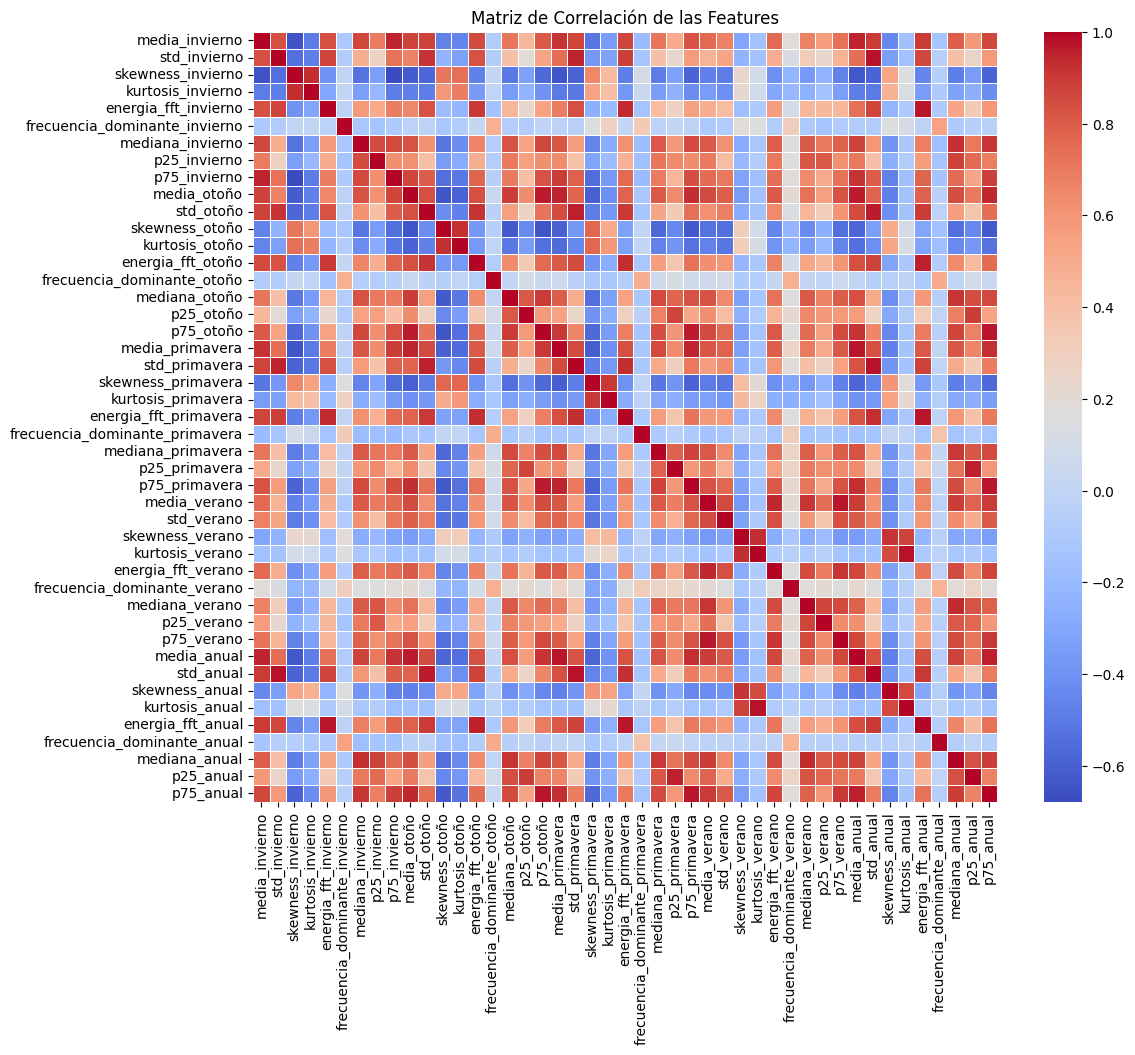


Pares de variables con baja correlación (abs(corr) < 0.05):

frecuencia_dominante_invierno - skewness_invierno: 0.003
frecuencia_dominante_invierno - kurtosis_invierno: -0.001
frecuencia_dominante_invierno - energia_fft_invierno: -0.025
media_otoño - frecuencia_dominante_invierno: -0.025
std_otoño - frecuencia_dominante_invierno: -0.025
energia_fft_otoño - frecuencia_dominante_invierno: 0.019
frecuencia_dominante_otoño - skewness_invierno: 0.020
frecuencia_dominante_otoño - kurtosis_invierno: -0.007
frecuencia_dominante_otoño - p75_invierno: -0.049
frecuencia_dominante_otoño - media_otoño: 0.038
frecuencia_dominante_otoño - std_otoño: -0.033
frecuencia_dominante_otoño - skewness_otoño: -0.049
frecuencia_dominante_otoño - kurtosis_otoño: -0.005
mediana_otoño - frecuencia_dominante_otoño: 0.010
p75_otoño - frecuencia_dominante_invierno: -0.011
p75_otoño - frecuencia_dominante_otoño: 0.037
media_primavera - frecuencia_dominante_invierno: -0.029
std_primavera - frecuencia_dominante_invier

In [19]:
correlation_matrix = df_features_final.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación de las Features')
plt.show()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

low_correlation_threshold = 0.05
low_correlated_pairs = [
    (column, row, upper_triangle.loc[row, column]) 
    for column in upper_triangle.columns 
    for row in upper_triangle.index 
    if abs(upper_triangle.loc[row, column]) < low_correlation_threshold
]

print(f"\nPares de variables con baja correlación (abs(corr) < {low_correlation_threshold}):\n")
for pair in low_correlated_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

high_correlation_threshold = 0.95
high_correlated_pairs = [
    (column, row, upper_triangle.loc[row, column]) 
    for column in upper_triangle.columns 
    for row in upper_triangle.index 
    if abs(upper_triangle.loc[row, column]) > high_correlation_threshold
]

print(f"\nPares de variables con ALTA correlación (abs(corr) > {high_correlation_threshold}):\n")
for pair in high_correlated_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

In [20]:
df_features_final.to_csv("dataset/generated_features.csv")

In [21]:
num_columnas = df_features_final.shape[1]
print(f"El DataFrame df_features_final tiene {num_columnas} columnas.")
nombres_columnas = df_features_final.columns.tolist()
print(f"Los nombres de las columnas son: {nombres_columnas}")

El DataFrame df_features_final tiene 45 columnas.
Los nombres de las columnas son: ['media_invierno', 'std_invierno', 'skewness_invierno', 'kurtosis_invierno', 'energia_fft_invierno', 'frecuencia_dominante_invierno', 'mediana_invierno', 'p25_invierno', 'p75_invierno', 'media_otoño', 'std_otoño', 'skewness_otoño', 'kurtosis_otoño', 'energia_fft_otoño', 'frecuencia_dominante_otoño', 'mediana_otoño', 'p25_otoño', 'p75_otoño', 'media_primavera', 'std_primavera', 'skewness_primavera', 'kurtosis_primavera', 'energia_fft_primavera', 'frecuencia_dominante_primavera', 'mediana_primavera', 'p25_primavera', 'p75_primavera', 'media_verano', 'std_verano', 'skewness_verano', 'kurtosis_verano', 'energia_fft_verano', 'frecuencia_dominante_verano', 'mediana_verano', 'p25_verano', 'p75_verano', 'media_anual', 'std_anual', 'skewness_anual', 'kurtosis_anual', 'energia_fft_anual', 'frecuencia_dominante_anual', 'mediana_anual', 'p25_anual', 'p75_anual']


In [22]:
columnas_invierno = [col for col in nombres_columnas if re.search(r'_invierno', col)]
columnas_primavera = [col for col in nombres_columnas if re.search(r'_primavera', col)]
columnas_verano = [col for col in nombres_columnas if re.search(r'_verano', col)]
columnas_otoño = [col for col in nombres_columnas if re.search(r'_otoño', col)]
columnas_anuales = [col for col in nombres_columnas if re.search(r'_anual', col)]

print("\nColumnas relacionadas con Invierno:")
print(len(columnas_invierno))
print(columnas_invierno)
print("\nColumnas relacionadas con Primavera:")
print(len(columnas_primavera))
print(columnas_primavera)
print("\nColumnas relacionadas con Verano:")
print(len(columnas_verano))
print(columnas_verano)
print("\nColumnas relacionadas con Otoño:")
print(len(columnas_otoño))
print(columnas_otoño)
print("\nColumnas con agregación Anual:")
print(len(columnas_anuales))
print(columnas_anuales)


Columnas relacionadas con Invierno:
9
['media_invierno', 'std_invierno', 'skewness_invierno', 'kurtosis_invierno', 'energia_fft_invierno', 'frecuencia_dominante_invierno', 'mediana_invierno', 'p25_invierno', 'p75_invierno']

Columnas relacionadas con Primavera:
9
['media_primavera', 'std_primavera', 'skewness_primavera', 'kurtosis_primavera', 'energia_fft_primavera', 'frecuencia_dominante_primavera', 'mediana_primavera', 'p25_primavera', 'p75_primavera']

Columnas relacionadas con Verano:
9
['media_verano', 'std_verano', 'skewness_verano', 'kurtosis_verano', 'energia_fft_verano', 'frecuencia_dominante_verano', 'mediana_verano', 'p25_verano', 'p75_verano']

Columnas relacionadas con Otoño:
9
['media_otoño', 'std_otoño', 'skewness_otoño', 'kurtosis_otoño', 'energia_fft_otoño', 'frecuencia_dominante_otoño', 'mediana_otoño', 'p25_otoño', 'p75_otoño']

Columnas con agregación Anual:
9
['media_anual', 'std_anual', 'skewness_anual', 'kurtosis_anual', 'energia_fft_anual', 'frecuencia_dominant